In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/Colab Notebooks/HAN

/content/drive/My Drive/Colab Notebooks/HAN


In [0]:
ls

IIITH_Codemixed.txt  MyNormalizer.py  __pycache__/  Untitled7.ipynb


In [0]:

import numpy as np
import h5py
import pickle
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing import sequence
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers import Conv1D
import tensorflow as tf

from keras.utils import np_utils
from MyNormalizer import token

################# GLOBAL VARIABLES #####################

inputdatasetfilename = 'IIITH_Codemixed.txt'


#Data I/O formatting
SEPERATOR = '\t'
DATA_COLUMN = 1
LABEL_COLUMN = 3
LABELS = ['0','1','2'] # 0 -> Negative, 1-> Neutral, 2-> Positive
mapping_char2num = {}
mapping_num2char = {}
MAXLEN = 200

#LSTM Model Parameters
#Embedding
MAX_FEATURES = 0
embedding_size = 128
# Convolution
filter_length = 3
nb_filter = 128
pool_length = 3
# LSTM
lstm_output_size = 128
# Training
batch_size = 128
number_of_epochs = 80
numclasses = 3
test_size = 0.2
########################################################

def parse(filename):
	"""
	Purpose -> Data I/O
	Input   -> Data file containing sentences and labels along with the global variables
	Output  -> Sentences cleaned up in list of lists format along with the labels as a numpy array
	"""
	#Reads the files and splits data into individual lines
	f=open(filename,'r',encoding='utf-8')
	lines = f.read().lower()
	lines = lines.lower().split('\n')[:-1]

	X_train = []
	Y_train = []
	
	#Processes individual lines
	for line in lines:
		# Seperator for the current dataset. Currently '\t'. 
		line = line.split(seperator)
		#Token is the function which implements basic preprocessing as mentioned in our paper
		tokenized_lines = token(line[datacol])
		
		#Creates character lists
		char_list = []
		for words in tokenized_lines:
			for char in words:
				char_list.append(char)
			char_list.append(' ')
		#print(char_list) - Debugs the character list created
		X_train.append(char_list)
		
		#Appends labels
		if line[labelcol] == labels[0]:
			Y_train.append(0)
		if line[labelcol] == labels[1]:
			Y_train.append(1)
		if line[labelcol] == labels[2]:
			Y_train.append(2)
	
	#Converts Y_train to a numpy array	
	Y_train = np.asarray(Y_train)
	assert(len(X_train) == Y_train.shape[0])

	return [X_train,Y_train]

def convert_char2num(mapping_n2c,mapping_c2n,trainwords,maxlen):
	"""
	Purpose -> Convert characters to integers, a unique value for every character
	Input   -> Training data (In list of lists format) along with global variables
	Output  -> Converted training data along with global variables
	"""
	allchars = []
	errors = 0

	#Creates a list of all characters present in the dataset
	for line in trainwords:
		try:
			allchars = set(allchars+line)
			allchars = list(allchars)
		except:
			errors += 1

	#print(errors) #Debugging
	#print(allchars) #Debugging 

	#Creates character dictionaries for the characters
	charno = 0
	for char in allchars:
		mapping_char2num[char] = charno
		mapping_num2char[charno] = char
		charno += 1

	assert(len(allchars)==charno) #Checks

	#Converts the data from characters to numbers using dictionaries 
	X_train = []
	for line in trainwords:
		char_list=[]
		for letter in line:
			char_list.append(mapping_char2num[letter])
		#print(no) -- Debugs the number mappings
		X_train.append(char_list)
	print(mapping_char2num)
	print(mapping_num2char)
	#Pads the X_train to get a uniform vector
	#TODO: Automate the selection instead of manual input
	X_train = sequence.pad_sequences(X_train[:], maxlen=maxlen)
	return [X_train,mapping_num2char,mapping_char2num,charno]

def RNN(X_train,y_train,args):
	"""
	Purpose -> Define and train the proposed LSTM network
	Input   -> Data, Labels and model hyperparameters
	Output  -> Trained LSTM network
	"""
	#Sets the model hyperparameters
	#Embedding hyperparameters
	max_features = args[0]
	maxlen = args[1]
	embedding_size = args[2]
	# Convolution hyperparameters
	filter_length = args[3]
	nb_filter = args[4]
	pool_length = args[5]
	# LSTM hyperparameters
	lstm_output_size = args[6]
	# Training hyperparameters
	batch_size = args[7]
	nb_epoch = args[8]
	numclasses = args[9]
	test_size = args[10] 

	#Format conversion for y_train for compatibility with Keras
	y_train = np_utils.to_categorical(y_train, numclasses) 
	#Train & Validation data splitting
	X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=42)
	
	#Build the sequential model
	# Model Architecture is:
	# Input -> Embedding -> Conv1D+Maxpool1D -> LSTM -> LSTM -> FC-1 -> Softmaxloss
	print('Build model...')
	model = Sequential()
	model.add(Embedding(max_features, embedding_size, input_length=maxlen))
	model.add(Convolution1D(nb_filter=nb_filter,
							filter_length=filter_length,
							border_mode='valid',
							activation='relu',
							subsample_length=1))
	model.add(MaxPooling1D(pool_length=pool_length))
	model.add(LSTM(lstm_output_size, dropout_W=0.2, dropout_U=0.2, return_sequences=True))
	model.add(LSTM(lstm_output_size, dropout_W=0.2, dropout_U=0.2, return_sequences=False))
	model.add(Dense(numclasses))
	model.add(Activation('softmax'))

	# Optimizer is Adamax along with categorical crossentropy loss
	model.compile(loss='categorical_crossentropy',optimizer='adamax',metrics=['accuracy'])
	

	print('Train...')
	#Trains model for 50 epochs with shuffling after every epoch for training data and validates on validation data
	history=model.fit(X_train, y_train, batch_size=batch_size, shuffle=True, nb_epoch=nb_epoch,validation_data=(X_valid, y_valid))
	return (model,history)



def get_activations(model, layer, X_batch):
	"""
	Purpose -> Obtains outputs from any layer in Keras
	Input   -> Trained model, layer from which output needs to be extracted & files to be given as input
	Output  -> Features from that layer 
	"""
	#Referred from:- TODO: Enter the forum link from where I got this
	get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
	activations = get_activations([X_batch,0])
	return activations

def evaluate_model(X_test,y_test,model,batch_size,numclasses):
	"""
	Purpose -> Evaluate any model on the testing data
	Input   -> Testing data and labels, trained model and global variables
	Output  -> Nil
	"""
	#Convert y_test to one-hot encoding
	y_test = np_utils.to_categorical(y_test, numclasses)
	#Evaluate the accuracies
	score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
	print('Test score:', score)
	print('Test accuracy:', acc)




In [0]:
    print('Starting RNN Engine...\nModel: Char-level LSTM.\nParsing data files...')
    out = parse(inputdatasetfilename)
    global X_train
    global y_train
    global X_test
    global y_test
    X_train = out[0]
    y_train = out[1]
    print(y_train)
    print('Parsing complete!')
    print('Creating character dictionaries and format conversion in progess...')
    out = convert_char2num(mapping_num2char,mapping_char2num,X_train,MAXLEN)
    mapping_num2char = out[1]
    mapping_char2num = out[2]
    MAX_FEATURES = out[3]
    X_train = np.asarray(out[0])
    y_train = np.asarray(y_train).flatten()
    print('Complete!')
    print('Splitting data into train and test...')
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    y_train=tf.keras.utils.to_categorical(y_train)
    y_test=tf.keras.utils.to_categorical(y_test)


Starting RNN Engine...
Model: Char-level LSTM.
Parsing data files...
[2 2 1 ... 2 2 2]
Parsing complete!
Creating character dictionaries and format conversion in progess...
{'k': 0, 'p': 1, 'c': 2, 'd': 3, 'f': 4, 'y': 5, 'x': 6, ' ': 7, 's': 8, 'm': 9, 'r': 10, 'z': 11, 'e': 12, 'o': 13, 't': 14, 'w': 15, 'u': 16, 'b': 17, 'g': 18, 'q': 19, 'h': 20, 'i': 21, 'v': 22, 'n': 23, 'j': 24, 'l': 25, 'a': 26}
{0: 'k', 1: 'p', 2: 'c', 3: 'd', 4: 'f', 5: 'y', 6: 'x', 7: ' ', 8: 's', 9: 'm', 10: 'r', 11: 'z', 12: 'e', 13: 'o', 14: 't', 15: 'w', 16: 'u', 17: 'b', 18: 'g', 19: 'q', 20: 'h', 21: 'i', 22: 'v', 23: 'n', 24: 'j', 25: 'l', 26: 'a'}
Complete!
Splitting data into train and test...


In [0]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 5.1MB/s 


In [0]:
#imports we know we'll need
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from keras.optimizers import Adamax

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',
                         name='learning_rate')
dim_no_epoch = Integer(low=20, high=80, name='no_epoch')
dim_embedding_size = Integer(low=16, high=256, name='embedding_size')
dim_lstm_output_size = Integer(low=16, high=256, name='lstm_output_size')
dim_pool_length =Integer(low=2,high=5,name='pool_length')
dim_batch_size = Integer(low=1, high=128, name='batch_size')
dim_adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")
dim_no_filter = Integer(low=16,high=256,name='no_filter')

dimensions = [dim_learning_rate,
              dim_batch_size,
              dim_adam_decay,
              dim_embedding_size,
              dim_lstm_output_size,
              dim_no_epoch,
              dim_no_filter,
             ]
default_parameters = [1e-3,32,1e-3, 128,128,50,128]

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate,batch_size,adam_decay,embedding_size,lstm_output_size,no_epoch,no_filter):
    model = Sequential()
    model.add(Embedding(MAX_FEATURES, embedding_size, input_length=MAXLEN))
    model.add(Convolution1D(nb_filter=no_filter,filter_length=filter_length,border_mode='valid',activation='relu',subsample_length=1))
    model.add(MaxPooling1D(pool_length=pool_length))
    model.add(LSTM(lstm_output_size, dropout_W=0.2, dropout_U=0.2, return_sequences=True))
    model.add(LSTM(lstm_output_size, dropout_W=0.2, dropout_U=0.2, return_sequences=False))
    model.add(Dense(numclasses))
    model.add(Activation('softmax'))
    
    admax=Adamax(lr=learning_rate,decay=adam_decay)
    
    model.compile(loss='categorical_crossentropy',optimizer=admax,metrics=['accuracy'])
    
    X_train1,X_valid,y_train1,y_valid=train_test_split(X_train,y_train,test_size=0.2,random_state=42)
    bb=model.fit(X_train1, y_train1, batch_size=batch_size, shuffle=True, nb_epoch=no_epoch,validation_data=(X_valid, y_valid))
    
    accuracy=bb.history['val_acc'][-1]
    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    tf.reset_default_graph()
    
    return -accuracy

In [0]:
K.clear_session()
tf.reset_default_graph()

In [0]:
gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=12,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=default_parameters)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.





Train on 2482 samples, validate on 621 samples
Epoch 1/50





2482/2482 [==============================] - 34s 14ms/step - loss: 0.9921 - acc: 0.5032 - val_loss: 1.0013 - val_acc: 0.4815
Epoch 2/50
2482/2482 [==============================] - 26s 11ms/step - loss: 0.9642 - acc: 0.5085 - val_loss: 0.9877 - val_acc: 0.4895
Epoch 3/50
2482/2482 [==============================] - 26s 11ms/step - loss: 0.9528 - acc: 0.5383 - val_loss: 0.9674 - val_acc: 0.5072
Epoch 4/50
2482/2482 [==============================] - 26s 11ms/step - loss: 0.9344 - acc: 0.5403 - val_loss: 0.9503 - val_acc: 0.5121
Epoch 5/50
2482/2482 [==============================] - 27s 11ms/step - loss: 0.9132 - acc: 0.5564 - val_loss: 0.9270 - val_acc: 0.5475
Epoch 6/50
2482/2482 [==============================] - 26s 11ms/step - loss: 0.8931 - acc: 0.5838 - val_loss: 0.8990 - val_acc: 0.5717
Epoch 7/50
2482/2482 [==============================] - 26s 11ms/step - loss: 0.8746 - acc: 0.5854 - val_loss: 0.8938 - val_acc: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=226, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(129, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(129, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/26
2482/2482 [==============================] - 10s 4ms/step - loss: 1.0413 - acc: 0.5008 - val_loss: 1.0188 - val_acc: 0.4815
Epoch 2/26
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9926 - acc: 0.5089 - val_loss: 1.0066 - val_acc: 0.4815
Epoch 3/26
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9828 - acc: 0.5089 - val_loss: 1.0009 - val_acc: 0.4815
Epoch 4/26
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9749 - acc: 0.5089 - val_loss: 0.9978 - val_acc: 0.4815
Epoch 5/26
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9704 - acc: 0.5089 - val_loss: 0.9966 - val_acc: 0.4815
Epoch 6/26
2482/2482 [==============================] - 7s 3ms/step - loss: 0.9673 - acc: 0.5097 - val_loss: 0.9921 - val_acc: 0.4815
Epoch 7/26
2482/2482 [==============================] - 8s 3ms/step - loss: 0.9661 - acc: 0.5101 - val_loss: 0.9936 - val_acc: 0.4815
Epoch 8/26
248

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=142, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(152, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(152, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/39
2482/2482 [==============================] - 12s 5ms/step - loss: 0.9983 - acc: 0.5012 - val_loss: 0.9894 - val_acc: 0.4960
Epoch 2/39
2482/2482 [==============================] - 10s 4ms/step - loss: 0.9624 - acc: 0.5165 - val_loss: 0.9881 - val_acc: 0.4944
Epoch 3/39
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9508 - acc: 0.5254 - val_loss: 0.9712 - val_acc: 0.5105
Epoch 4/39
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9280 - acc: 0.5528 - val_loss: 0.9535 - val_acc: 0.5072
Epoch 5/39
2482/2482 [==============================] - 9s 4ms/step - loss: 0.9063 - acc: 0.5681 - val_loss: 0.9447 - val_acc: 0.5282
Epoch 6/39
2482/2482 [==============================] - 10s 4ms/step - loss: 0.8904 - acc: 0.5782 - val_loss: 0.9074 - val_acc: 0.5523
Epoch 7/39
2482/2482 [==============================] - 9s 4ms/step - loss: 0.8636 - acc: 0.6019 - val_loss: 0.9064 - val_acc: 0.5475
Epoch 8/39
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=94, kernel_size=3, strides=1, padding="valid")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=3)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(244, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(244, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2482 samples, validate on 621 samples
Epoch 1/40
2482/2482 [==============================] - 64s 26ms/step - loss: 0.9869 - acc: 0.5073 - val_loss: 0.9915 - val_acc: 0.4815
Epoch 2/40
2482/2482 [==============================] - 61s 25ms/step - loss: 0.9671 - acc: 0.5121 - val_loss: 0.9846 - val_acc: 0.4911
Epoch 3/40
2482/2482 [==============================] - 62s 25ms/step - loss: 0.9606 - acc: 0.5250 - val_loss: 0.9978 - val_acc: 0.4944
Epoch 4/40
2482/2482 [==============================] - 61s 25ms/step - loss: 0.9490 - acc: 0.5379 - val_loss: 0.9750 - val_acc: 0.4992
Epoch 5/40
2482/2482 [==============================] - 62s 25ms/step - loss: 0.9440 - acc: 0.5443 - val_loss: 0.9649 - val_acc: 0.4767
Epoch 6/40
2482/2482 [==============================] - 61s 25ms/step - loss: 0.9298 - acc: 0.5564 - val_loss: 0.9669 - val_acc: 0.5056
Epoch 7/40
2482/2482 [==============================] - 61s 25ms/step - loss: 0.9196 - acc: 0.5564 - val_loss: 0.9489 - val_acc: 0.5105
E

In [0]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 6.8MB/s 


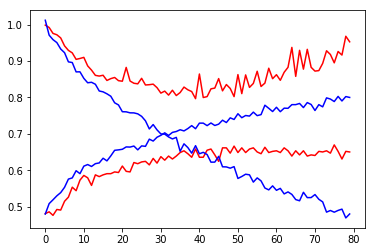

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'],'r')
plt.plot(history.history['val_acc'],'r')
plt.plot(history.history['loss'],'b')
plt.plot(history.history['acc'],'b')


SyntaxError: ignored